# Takeaway Data Analysis

In [0]:
# Importing libraries
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import to_timestamp, trim, to_date, year, month
from pyspark.sql.functions import lit
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import col, sum, when

from IPython.display import clear_output

import itertools
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
#%pip install prophet # Installs profit for the notebook
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

## Data Handling

### Reading in Data

In [0]:
restaurant1 = spark.read.load('/FileStore/tables/restaurant_1_orders.csv', format='csv', header=True, inferSchema=True)
restaurant1_price = spark.read.load('/FileStore/tables/restaurant_1_products_price.csv', format='csv', header=True, inferSchema=True)
restaurant2 = spark.read.load('/FileStore/tables/restaurant_2_orders.csv', format='csv', header=True, inferSchema=True)
restaurant2_price = spark.read.load('/FileStore/tables/restaurant_2_products_price.csv', format='csv', header=True, inferSchema=True)

Below we add identifier columns for the restaurant an entry belongs to for when we merge the datasets

In [0]:
# Add a restaurant ID to each DataFrame
restaurant1 = restaurant1.withColumn("restaurant", lit("1"))
restaurant2 = restaurant2.withColumn("restaurant", lit("2"))

Then we merge the datasets with `.union()` so we get all the data from both dataframes

In [0]:
# Merge the two DataFrame
restaurants = restaurant1.union(restaurant2)

In [0]:
# View the resultant dataframe
restaurants.show(5, truncate=False)

+------------+----------------+-------------------+--------+-------------+--------------+----------+
|Order Number|Order Date      |Item Name          |Quantity|Product Price|Total products|restaurant|
+------------+----------------+-------------------+--------+-------------+--------------+----------+
|16118       |03/08/2019 20:25|Plain Papadum      |2       |0.8          |6             |1         |
|16118       |03/08/2019 20:25|King Prawn Balti   |1       |12.95        |6             |1         |
|16118       |03/08/2019 20:25|Garlic Naan        |1       |2.95         |6             |1         |
|16118       |03/08/2019 20:25|Mushroom Rice      |1       |3.95         |6             |1         |
|16118       |03/08/2019 20:25|Paneer Tikka Masala|1       |8.95         |6             |1         |
+------------+----------------+-------------------+--------+-------------+--------------+----------+
only showing top 5 rows



In [0]:
restaurants.printSchema()

root
 |-- Order Number: integer (nullable = true)
 |-- Order Date: string (nullable = true)
 |-- Item Name: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Product Price: double (nullable = true)
 |-- Total products: integer (nullable = true)
 |-- restaurant: string (nullable = false)



In [0]:
# Check the number of Unique Order ID's to check total order count after merge
restaurants.groupBy('restaurant').agg(countDistinct('Order Number').alias('Total_Order_Count')).show()

+----------+-----------------+
|restaurant|Total_Order_Count|
+----------+-----------------+
|         1|            13397|
|         2|            19658|
+----------+-----------------+



In [0]:
# Convert 'Order Date' to a timestamp column to preserve the time
restaurants = restaurants.withColumn("Order_Date", to_timestamp(trim(col("Order Date")), "dd/MM/yyyy HH:mm")).drop('Order Date')

In [0]:
# Summary statistics
restaurants.describe("Quantity", "Product Price", "Total products").show()

+-------+------------------+-----------------+------------------+
|summary|          Quantity|    Product Price|    Total products|
+-------+------------------+-----------------+------------------+
|  count|            194001|           194001|            194001|
|   mean|1.2468234699821135| 5.17694316009051| 7.124947809547374|
| stddev|0.7407056574275939|3.259806009899443|3.3749297549746404|
|    min|                 1|              0.5|                 1|
|    max|                51|            17.95|                60|
+-------+------------------+-----------------+------------------+



In [0]:
# We can check the number of null values for each column in the dataframe

null_counts = restaurants.select(
    *[
        sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
        for c in restaurants.columns
    ]
)

null_counts.show() # No missing values

+------------+---------+--------+-------------+--------------+----------+----------+
|Order Number|Item Name|Quantity|Product Price|Total products|restaurant|Order_Date|
+------------+---------+--------+-------------+--------------+----------+----------+
|           0|        0|       0|            0|             0|         0|         0|
+------------+---------+--------+-------------+--------------+----------+----------+



## Data exploration

In [0]:
# Extract the Year and Month for each order for time analysis
restaurants = restaurants.withColumn('Year', year('Order_Date')) \
                         .withColumn('Month', month('Order_Date'))


In [0]:
# To create a time series graph to showcase orders by month/year by restaurant we need to first create a separate dataframe to count the number of orders per month/year by restaurant

orders_by_month_restaurant = restaurants.groupBy('restaurant','Year', 'Month').agg(countDistinct('Order Number').alias('Order_Count')).orderBy('restaurant','Year', 'Month')
orders_by_month_restaurant.show(5)

+----------+----+-----+-----------+
|restaurant|Year|Month|Order_Count|
+----------+----+-----+-----------+
|         1|2015|    9|         17|
|         1|2015|   10|         12|
|         1|2016|    3|        112|
|         1|2016|    4|        160|
|         1|2016|    5|        179|
+----------+----+-----+-----------+
only showing top 5 rows



In [0]:
# Need to convert the dataframe from Spark to Pandas
order_month_pd = orders_by_month_restaurant.toPandas()

# Create a combined column for year and month for the time series x-axis
order_month_pd['Year-Month'] = order_month_pd['Year'].astype(str) + '-' + order_month_pd['Month'].apply(lambda m: f"{m:02d}")

# Order it by year and month
order_month_pd = order_month_pd.sort_values(by=['restaurant','Year', 'Month'])


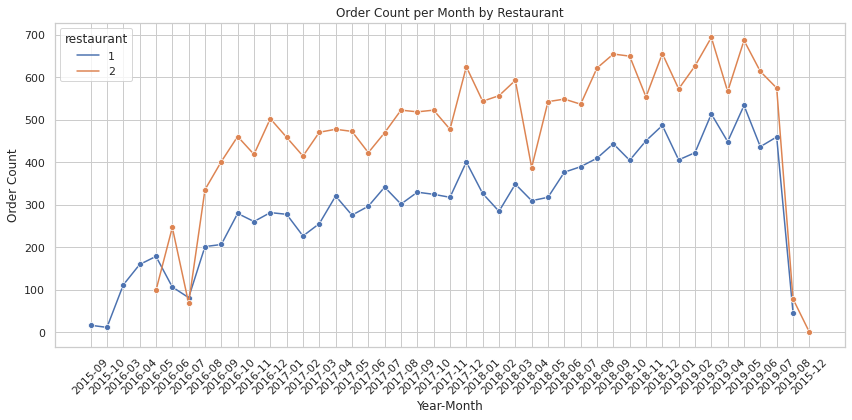

In [0]:
# Create line graph for order counts for both restaurants
sns.set(style='whitegrid')

plt.figure(figsize=(12, 6))
sns.lineplot(data=order_month_pd, x='Year-Month', y='Order_Count', hue='restaurant', marker='o')

plt.xlabel('Year-Month')
plt.ylabel('Order Count')
plt.title('Order Count per Month by Restaurant')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The line plots showcase a slight upwards trend for both restaurants, with some seasonality. The final months for each restaurant appear to have incomplete data as the order counts are extremely low.

<br>

Restaurant 1 clearly has lower order counts than restaurant 2, indicating that restaurant 2 is more successful. The trends appear to be quite similar between the two restaurants.

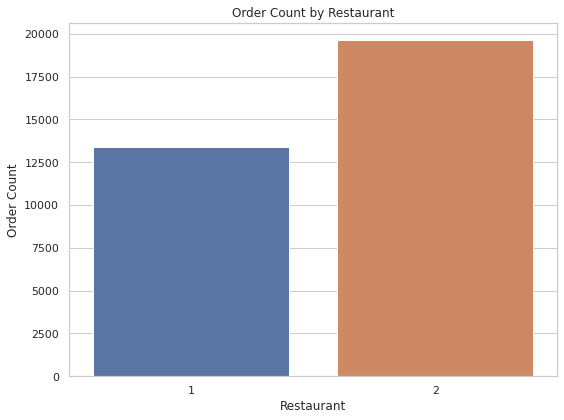

In [0]:
# Next we may be interested in the number of orders per restaurant

orders_by_restaurant = restaurants.groupBy('restaurant').agg(countDistinct('Order Number').alias('Order Count')).orderBy('restaurant')

pdf_orders = orders_by_restaurant.toPandas()

sns.set(style='whitegrid')

plt.figure(figsize=(8, 6))
sns.barplot(data=pdf_orders, x='restaurant', y='Order Count')
plt.xlabel('Restaurant')
plt.ylabel('Order Count')
plt.title('Order Count by Restaurant')
plt.tight_layout()
plt.show()


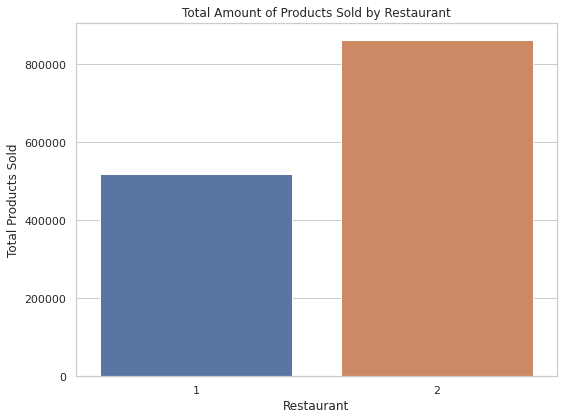

In [0]:
# Next, which restaurant sold the most individual item/products?

products_by_restaurant = restaurants.groupBy('restaurant') \
    .agg(sum('Total products').alias('Total_Products_Sold')) \
    .orderBy('restaurant')

pdf_products = products_by_restaurant.toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(data=pdf_products, x='restaurant', y='Total_Products_Sold')
plt.xlabel('Restaurant')
plt.ylabel('Total Products Sold')
plt.title('Total Amount of Products Sold by Restaurant')
plt.tight_layout()
plt.show()

The above barplots show the number of orders and number of products sold overall for both restaurants. As expected from the lineplot, restaurant 2 has higher order counts and products sold. There appears to be a slightly larger difference in the products sold barplot, indicating that people tend to purchase more products in restaurant 2 per order.

## Time Series Forecasting

In [0]:
# We can undertake time series forecasting on total profit

# First we want to create a column for sale-profit for each sale
restaurants = restaurants.withColumn('Sale_Profit', col('Product Price') * col('Quantity'))

# Next we need to aggragate the profit for each order as there can be multiple items purchased within an order
order_sales = restaurants.groupBy('restaurant', 'Order Number', 'Order_Date').agg(sum('Sale_Profit').alias('Order_Sale_Profit'))

# Now add the Year and Month columns
order_sales = order_sales.withColumn('Year', year('Order_Date')).withColumn('Month', month('Order_Date')).drop('Order_Date')



In [0]:
# Now we aggregate over all the orders for each month
monthly_sales = order_sales.groupBy('restaurant', 'Year', 'Month').agg(sum('Order_Sale_Profit').alias('Total_Sales_Profit')).orderBy('restaurant', 'Year', 'Month')

monthly_sales.show()

+----------+----+-----+------------------+
|restaurant|Year|Month|Total_Sales_Profit|
+----------+----+-----+------------------+
|         1|2015|    9|189.04999999999998|
|         1|2015|   10|223.45000000000002|
|         1|2016|    3| 3511.099999999998|
|         1|2016|    4|5520.4000000000015|
|         1|2016|    5| 6121.200000000001|
|         1|2016|    6|3576.0000000000005|
|         1|2016|    7| 2810.149999999999|
|         1|2016|    8| 6560.650000000003|
|         1|2016|    9| 7175.400000000002|
|         1|2016|   10| 9787.750000000007|
|         1|2016|   11| 8928.150000000007|
|         1|2016|   12|            9988.0|
|         1|2017|    1| 9606.999999999996|
|         1|2017|    2| 7793.099999999998|
|         1|2017|    3|           8518.45|
|         1|2017|    4| 10669.60000000001|
|         1|2017|    5| 8890.150000000001|
|         1|2017|    6|10106.949999999995|
|         1|2017|    7|11503.399999999996|
|         1|2017|    8|10179.249999999993|
+----------

In [0]:
# Cast the restaurant ID column into int for filtering
monthly_sales = monthly_sales.withColumn('restaurant', col('restaurant').cast('int'))
monthly_sales.dtypes

Out[19]: [('restaurant', 'int'),
 ('Year', 'int'),
 ('Month', 'int'),
 ('Total_Sales_Profit', 'double')]

In [0]:
def prepare_data(monthly_sales, restaurant_id):
  
    # Filter by restaurant and convert to pandas
    monthly_sales_pd = monthly_sales.filter(col('restaurant') == restaurant_id).toPandas()
    
    # Create a datetime column combining Year and Month
    monthly_sales_pd['ds'] = pd.to_datetime(
        monthly_sales_pd['Year'].astype(str) + '-' +
        monthly_sales_pd['Month'].apply(lambda x: f'{x:02d}') + '-01'
    )
    
    # Remove the last month of data (assumed to be an outlier)
    max_date = monthly_sales_pd['ds'].max()
    monthly_sales_pd = monthly_sales_pd[monthly_sales_pd['ds'] != max_date]
    
    # Select and rename columns to fit Prophet's requirements
    df_sales = monthly_sales_pd[['ds', 'Total_Sales_Profit']].rename(columns={'Total_Sales_Profit': 'y'})
    return df_sales

In [0]:
def compute_time_splits(df_sales, train_pct=0.8, period_pct=0.05):
    
    ds_min = df_sales['ds'].min()
    ds_max = df_sales['ds'].max()
    total_days = (ds_max - ds_min).days # Compute total dataset length in days
    
    initial_days = int(total_days * train_pct) # Create training length in days
    horizon_days = total_days - initial_days # Create test length in days
    period_days  = int(total_days * period_pct) # Create cutoff spacing in days
    
    print('Total days in dataset:', total_days)
    print('Initial training period (days):', initial_days)
    print('Horizon (test period) (days):', horizon_days)
    print('Period (cutoff spacing) (days):', period_days)
    
    return total_days, initial_days, horizon_days, period_days

In [0]:
def tune_prophet_model(df_sales, initial_days, period_days, horizon_days, param_grid=None):
    
    if param_grid is None: # If no parameter grid is provided, use this as the default
        param_grid = {
            'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
            'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0], # Not including holiday_prior_scale as there is no known holidays
            'seasonality_mode': ['additive', 'multiplicative']
        }
    
    # Create a list of all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    rmses = []
    
    # Iterate over all parameters and perform cross validation
    for params in all_params:
        m = Prophet(**params)
        m.fit(df_sales)
        # Convert day counts to strings acceptable by cross_validation function in Prophet
        df_cv = cross_validation(m, 
                                 initial=f'{initial_days} days', 
                                 period=f'{period_days} days', 
                                 horizon=f'{horizon_days} days')
        df_p = performance_metrics(df_cv, rolling_window=1)
        rmse = df_p['rmse'].values[0]
        rmses.append(rmse)
    
    # Compile the results into a DataFrame and select the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results['rmse'] = rmses
    best_params = tuning_results.sort_values(by='rmse').iloc[0]
    
    print('Best Parameters:')
    print(best_params)
    
    best_params = best_params.drop('rmse').to_dict()

    return best_params, tuning_results

In [0]:
def train_forecast_model(df_sales, best_params, forecast_periods=12, freq='MS'):
   
    model = Prophet(**best_params)
    model.fit(df_sales, show_console=False)
    clear_output(wait=True) # Clears log outputs from fitting model

    future = model.make_future_dataframe(periods=forecast_periods, freq=freq)
    forecast = model.predict(future)
    
    return model, forecast

In [0]:
def plot_forecast(model, forecast, restaurant_id):
   
    fig = model.plot(forecast)
    plt.title(f'Forecast of Total Sales/Profit for Restaurant {restaurant_id}')
    plt.xlabel('Date')
    plt.ylabel('Total Sales/Profit')
    plt.show()


    fig2 = model.plot_components(forecast)
    plt.show()  

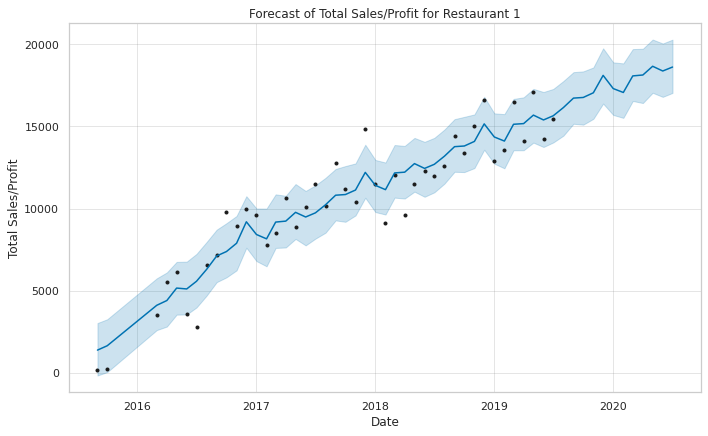

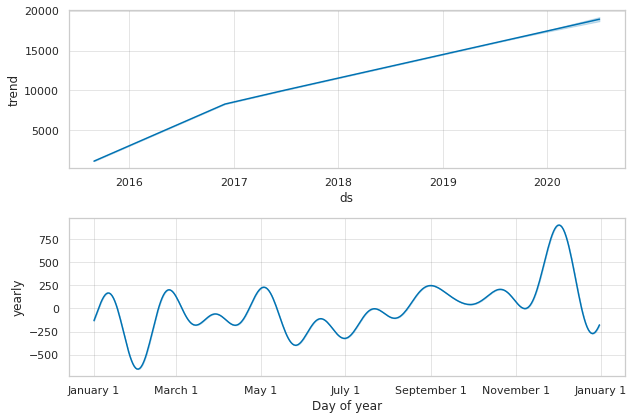

In [0]:
restaurant_id = 1

df_sales = prepare_data(monthly_sales, restaurant_id)
    

total_days, initial_days, horizon_days, period_days = compute_time_splits(df_sales)
    
   
best_params, tuning_results = tune_prophet_model(df_sales, initial_days, period_days, horizon_days)
    

model, forecast = train_forecast_model(df_sales, best_params)
    

plot_forecast(model, forecast, restaurant_id)



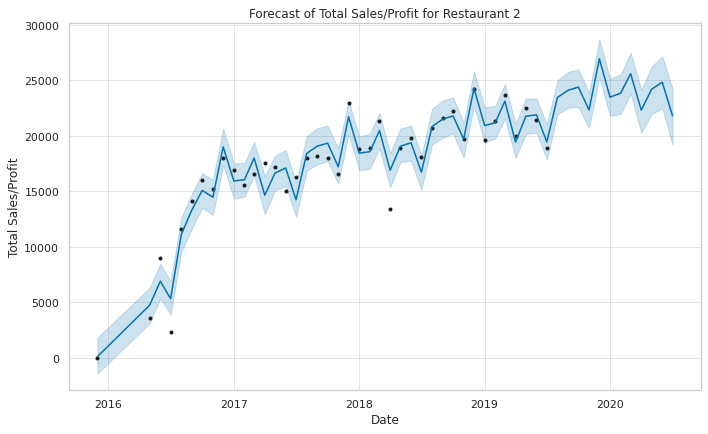

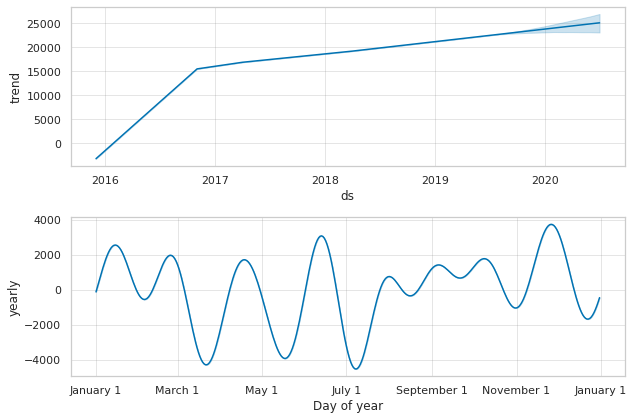

In [0]:
restaurant_id = 2

df_sales = prepare_data(monthly_sales, restaurant_id)
    

total_days, initial_days, horizon_days, period_days = compute_time_splits(df_sales)
    
   
best_params, tuning_results = tune_prophet_model(df_sales, initial_days, period_days, horizon_days)
    

model, forecast = train_forecast_model(df_sales, best_params)
    

plot_forecast(model, forecast, restaurant_id)